In [1]:
#Compilo todo el codigo (Es lo mismo que hace la notebook knn, es para tenerlo a mano)
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Found libomp without any special flags
-- Found PythonInterp: /home/luciano/tp2-metodos-numericos/tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86

# Imports y algoritmos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import metnum as mn
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score
from time import time

In [3]:
#Algoritmo de kFold
def kFold(K,sizeX):
    kfold = []
    aux = 0
    tamañoDelFold = np.ceil(sizeX/K)
    while(aux < sizeX):
        indice = aux+tamañoDelFold
        if(indice > sizeX):
            indice = sizeX
            
        indices = [int(aux),int(indice)]
        kfold.append(indices)
        aux += tamañoDelFold
    return kfold

#Algoritmo de crossValidation
def kFoldCrossValidation(k,K,X,y,alpha=0):
    kfold = kFold(K,X.shape[0])
    sumKappa,sumAcc,sumF1,sumRecall = 0,0,0,0
    result = []
    X_copy = X
    
    if(alpha != 0):
        pca = mn.PCA(alpha)
        pca.fit(X_copy)
        X_copy = pca.transform(X_copy)
        
    for i in range(len(kfold)):
        aux = kfold[i]
        #Separo el data set en datos de entrenamiento y de validacion
        X_test = X_copy[aux[0]:aux[1]]
        y_test = y[aux[0]:aux[1]]
        X_train = np.concatenate((X_copy[:aux[0]+1], X_copy[aux[1]:]), axis=0)
        y_train = np.concatenate((y[:aux[0]+1], y[aux[1]:]), axis=0)

        #Hago una prediccion con mi modelo
        model = mn.KNNClassifier(k)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        #Sumamos las metricas
        sumKappa += cohen_kappa_score(y_test, y_pred)
        sumAcc += accuracy_score(y_test, y_pred)
        sumF1 += f1_score(y_test, y_pred, average="macro")
        sumRecall += recall_score(y_test, y_pred, average="macro")
    
    result = [sumKappa,sumAcc,sumF1,sumRecall]
    result = list(map(lambda x: x / len(kfold), result))
    
    return result

## Cargo el dataset

In [4]:
#Me guardo los datos de entrenamiento
df = pd.read_csv("../data/train.csv")

In [5]:
df_cortado = df[:25000]
#Divido el dataset en train y test (Importante el random_state para salvar el caso donde el dataset esta ordenado)
df_train, df_test = train_test_split(df_cortado, test_size = 0.30, random_state = 69)

In [6]:
#Me guardo las imagenes y los labels por separado
X_train = df_train[df_train.columns[1:]].values
y_train = df_train["label"].values.reshape(-1,1)
X_test = df_test[df_test.columns[1:]].values
y_test = df_test["label"].values.reshape(-1,1)

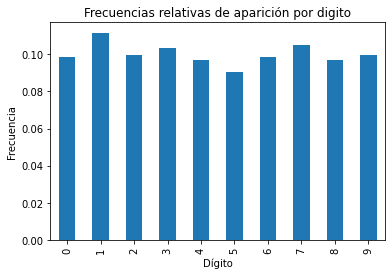

In [7]:
#Balance de datos
value_counts = df["label"].value_counts(normalize=True,sort=False)
value_counts.plot(kind = 'bar')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.title('Frecuencias relativas de aparición por digito')
plt.show()

## Análisis del K de K-Fold

In [8]:
from tqdm import tqdm

In [9]:
k = [1,5,9]
listaDeKs = []
for i in range(35):
    listaDeKs.append(i+1)

metricas_sinPCA = []
# Metricas sin PCA, tendrá en la posición i, los accuracy conseguidos con k_ = k[i] (osea una lista)

for k_ in k:
    aux = []
    for K_ in tqdm(listaDeKs):
        aux.append(kFoldCrossValidation(k_,K_,X_train,y_train))
    metricas_sinPCA.append(aux)

100%|██████████| 35/35 [1:35:55<00:00, 164.45s/it]


In [10]:
k1 = metricas_sinPCA[0]
k5 = metricas_sinPCA[1]
k9 = metricas_sinPCA[2]

#[sumKappa,sumAcc,sumF1,sumRecall]

In [11]:
kappa_k1,acc_k1,f1_k1,recall_k1 = [],[],[],[]
kappa_k5,acc_k5,f1_k5,recall_k5 = [],[],[],[]
kappa_k9,acc_k9,f1_k9,recall_k9 = [],[],[],[]

for i in k1:
    kappa_k1.append(i[0])
    acc_k1.append(i[1])
    f1_k1.append(i[2])
    recall_k1.append(i[3])
    
for i in k5:
    kappa_k5.append(i[0])
    acc_k5.append(i[1])
    f1_k5.append(i[2])
    recall_k5.append(i[3])
    
for i in k9:
    kappa_k9.append(i[0])
    acc_k9.append(i[1])
    f1_k9.append(i[2])
    recall_k9.append(i[3])

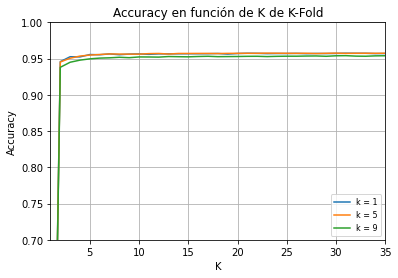

In [12]:
plt.plot(listaDeKs,acc_k1,label= "k = 1")
plt.plot(listaDeKs,acc_k5,label= "k = 5")
plt.plot(listaDeKs,acc_k9,label= "k = 9")
plt.xlim(1,len(listaDeKs),1)
plt.ylim(0.7,1)
plt.grid()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy en función de K de K-Fold')
plt.legend(fontsize=8)
plt.show()

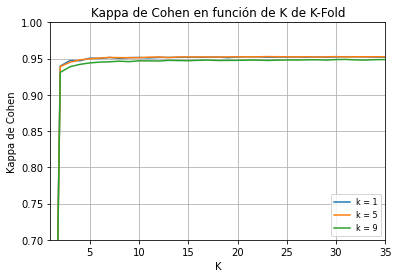

In [13]:
plt.plot(listaDeKs,kappa_k1,label= "k = 1")
plt.plot(listaDeKs,kappa_k5,label= "k = 5")
plt.plot(listaDeKs,kappa_k9,label= "k = 9")
plt.xlim(1,len(listaDeKs),1)
plt.ylim(0.7,1)
plt.grid()
plt.xlabel('K')
plt.ylabel('Kappa de Cohen')
plt.title('Kappa de Cohen en función de K de K-Fold')
plt.legend(fontsize=8)
plt.show()

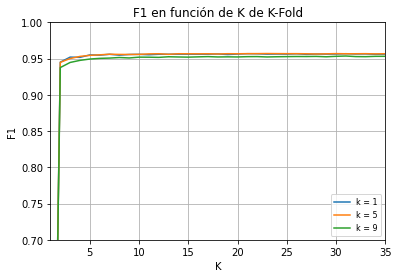

In [14]:
plt.plot(listaDeKs,f1_k1,label= "k = 1")
plt.plot(listaDeKs,f1_k5,label= "k = 5")
plt.plot(listaDeKs,f1_k9,label= "k = 9")
plt.xlim(1,len(listaDeKs),1)
plt.ylim(0.7,1)
plt.grid()
plt.xlabel('K')
plt.ylabel('F1')
plt.title('F1 en función de K de K-Fold')
plt.legend(fontsize=8)
plt.show()

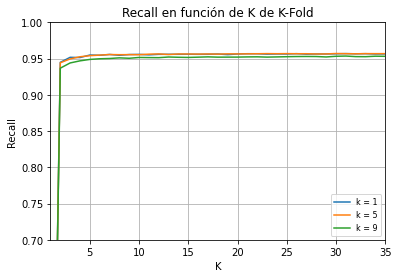

In [15]:
plt.plot(listaDeKs,recall_k1,label= "k = 1")
plt.plot(listaDeKs,recall_k5,label= "k = 5")
plt.plot(listaDeKs,recall_k9,label= "k = 9")
plt.xlim(1,len(listaDeKs),1)
plt.ylim(0.7,1)
plt.grid()
plt.xlabel('K')
plt.ylabel('Recall')
plt.title('Recall en función de K de K-Fold')
plt.legend(fontsize=8)
plt.show()

# Relación con el tamaño de la muestra

Veo como para distintos K de K-Fold, cambian las métricas en función de su tamaño

In [16]:
tamaño = np.arange(100,5001,200)
K = [10,20,30,40,50] #Dejo K fijo en 10, por lo visto antes

metricas = []
for K_ in K:
    aux = []
    for tam in tqdm(tamaño):
            df_aux = df[:int(tam)]
            df_train_1, df_test_1 = train_test_split(df_aux, test_size = 0.01, random_state = 69)

            X_train = df_train_1[df_train.columns[1:]].values
            y_train = df_train_1["label"].values.reshape(-1,1)

            aux.append(kFoldCrossValidation(3,K_,X_train,y_train))
    metricas.append(aux)

  0%|          | 0/25 [00:00<?, ?it/s]/home/luciano/tp2-metodos-numericos/tp2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/tp2-metodos-numericos/tp2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/tp2-metodos-numericos/tp2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home

In [17]:
# K = [10,20,30,40,50]
k10 = metricas[0] 
k20 = metricas[1] 
k30 = metricas[2] 
k40 = metricas[3] 
k50 = metricas[4] 

In [18]:
kappa_k10,acc_k10,f1_k10,recall_k10 = [],[],[],[]
kappa_k20,acc_k20,f1_k20,recall_k20 = [],[],[],[]
kappa_k30,acc_k30,f1_k30,recall_k30 = [],[],[],[]
kappa_k40,acc_k40,f1_k40,recall_k40 = [],[],[],[]
kappa_k50,acc_k50,f1_k50,recall_k50 = [],[],[],[]

for i in k10:
    kappa_k10.append(i[0])
    acc_k10.append(i[1])
    f1_k10.append(i[2])
    recall_k10.append(i[3])
    
for i in k20:
    kappa_k20.append(i[0])
    acc_k20.append(i[1])
    f1_k20.append(i[2])
    recall_k20.append(i[3])
    
for i in k30:
    kappa_k30.append(i[0])
    acc_k30.append(i[1])
    f1_k30.append(i[2])
    recall_k30.append(i[3])
    
for i in k40:
    kappa_k40.append(i[0])
    acc_k40.append(i[1])
    f1_k40.append(i[2])
    recall_k40.append(i[3])
    
for i in k50:
    kappa_k50.append(i[0])
    acc_k50.append(i[1])
    f1_k50.append(i[2])
    recall_k50.append(i[3])

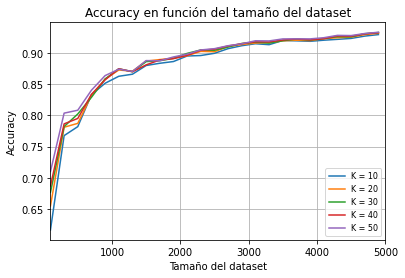

In [23]:
plt.plot(tamaño,acc_k10,label= "K = 10")
plt.plot(tamaño,acc_k20,label= "K = 20")
plt.plot(tamaño,acc_k30,label= "K = 30")
plt.plot(tamaño,acc_k40,label= "K = 40")
plt.plot(tamaño,acc_k50,label= "K = 50")
plt.xlim(100,5000)
#plt.ylim(0.65,0.95)
plt.grid()
plt.xlabel('Tamaño del dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy en función del tamaño del dataset')
plt.legend(fontsize=8)
plt.show()

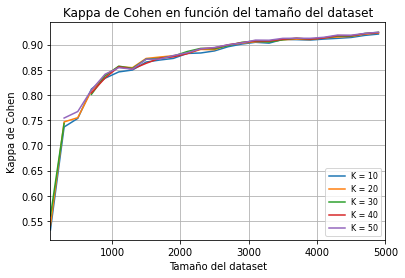

In [20]:
plt.plot(tamaño,kappa_k10,label= "K = 10")
plt.plot(tamaño,kappa_k20,label= "K = 20")
plt.plot(tamaño,kappa_k30,label= "K = 30")
plt.plot(tamaño,kappa_k40,label= "K = 40")
plt.plot(tamaño,kappa_k50,label= "K = 50")
plt.xlim(100,5000)
#plt.ylim(0.65,0.95)
plt.grid()
plt.xlabel('Tamaño del dataset')
plt.ylabel('Kappa de Cohen')
plt.title('Kappa de Cohen en función del tamaño del dataset')
plt.legend(fontsize=8)
plt.show()

In [21]:
plt.plot(tamaño,f1_k10,label= "K = 10")
plt.plot(tamaño,f1_k20,label= "K = 20")
plt.plot(tamaño,f1_k30,label= "K = 30")
plt.plot(tamaño,f1_k40,label= "K = 40")
plt.plot(tamaño,f1_k50,label= "K = 50")
plt.xlim(100,5000)
#plt.ylim(0.65,0.95)
plt.grid()
plt.xlabel('Tamaño del dataset')
plt.ylabel('F1')
plt.title('F1 en función del tamaño del dataset')
plt.legend(fontsize=8)
plt.show()

In [22]:
plt.plot(tamaño,recall_k10,label= "K = 10")
plt.plot(tamaño,recall_k20,label= "K = 20")
plt.plot(tamaño,recall_k30,label= "K = 30")
plt.plot(tamaño,recall_k40,label= "K = 40")
plt.plot(tamaño,recall_k50,label= "K = 50")
plt.xlim(100,5000)
#plt.ylim(0.65,0.95)
plt.grid()
plt.xlabel('Tamaño del dataset')
plt.ylabel('Recall')
plt.title('Recall en función del tamaño del dataset')
plt.legend(fontsize=8)
plt.show()